## Visualizing ConvNet Filters after training

### Based on keras tutorial documentations

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# The dimensions of our input image
img_width = 720
img_height = 720

# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
layer_name = "conv5_block3_3_conv"

In [74]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = keras.applications.ResNet50(weights="imagenet", include_top=False)

# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

# print(model.summary())

In [75]:
def compute_loss(input_image, filter_index):

    # Forward propagation through model from input to designated output layer
    activation = feature_extractor(input_image)
    
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

In [76]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)

    # Compute gradients.
    grads = tape.gradient(loss, img)
    
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img

In [77]:
def initialize_image(file=None):

    if(file==None):
        # We start from a gray image with some random noise
        img = tf.random.uniform((1, img_width, img_height, 3))
        # ResNet50V2 expects inputs in the range [-1, +1].
        # Here we scale our random inputs to [-0.125, +0.125]
        return (img - 0.5) * 0.25
    else:
        from PIL import Image
        img = Image.open(file)
        img = img.resize((360, 360))
        img = np.array(img)
        img = img.reshape((1, 360, 360, 3))
        print(img.shape)
        return img/255
        


def visualize_filter(filter_index, file=None):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 10.0
    img = initialize_image(file)
    
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [80]:
from IPython.display import Image, display

loss, img = visualize_filter(4, file=None)
keras.preprocessing.image.save_img("0.png", img)

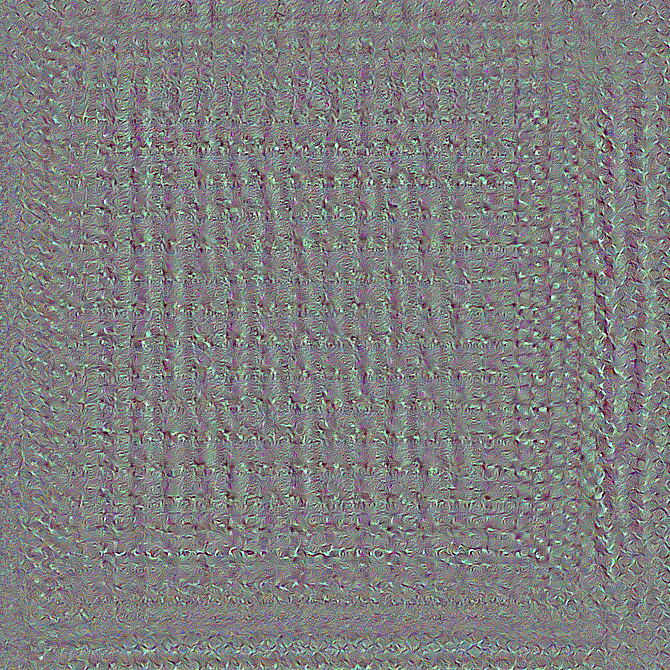

In [81]:
display(Image("0.png"))

## On Google Deepdream what basically happens is that we choose number of layers and in the loss calculation we calculate the loss related to all those layers. and in the gradient ascent we maximize the loss (NOT MINIMIZE) to make sure filter features get prominent in subsequant iterations. Thats it!